# Практика застосування логістичної регресії. EDA датасету Rain in Australia

### Знайомство з даними

In [82]:
import warnings
import pandas as pd
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline



In [83]:
data = pd.read_csv('../datasets/mod_03_topic_05_weather_data.csv.gz')
data.shape

(145460, 23)

In [84]:
data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [85]:
data.dtypes

Date              object
Location          object
MinTemp          float64
MaxTemp          float64
Rainfall         float64
Evaporation      float64
Sunshine         float64
WindGustDir       object
WindGustSpeed    float64
WindDir9am        object
WindDir3pm        object
WindSpeed9am     float64
WindSpeed3pm     float64
Humidity9am      float64
Humidity3pm      float64
Pressure9am      float64
Pressure3pm      float64
Cloud9am         float64
Cloud3pm         float64
Temp9am          float64
Temp3pm          float64
RainToday         object
RainTomorrow      object
dtype: object

### Перевірка на наявність пропущених значень

In [86]:
data.isna().mean().sort_values(ascending=False)

Sunshine         0.480098
Evaporation      0.431665
Cloud3pm         0.408071
Cloud9am         0.384216
Pressure9am      0.103568
Pressure3pm      0.103314
WindDir9am       0.072639
WindGustDir      0.070989
WindGustSpeed    0.070555
Humidity3pm      0.030984
WindDir3pm       0.029066
Temp3pm          0.024811
RainTomorrow     0.022460
Rainfall         0.022419
RainToday        0.022419
WindSpeed3pm     0.021050
Humidity9am      0.018246
Temp9am          0.012148
WindSpeed9am     0.012148
MinTemp          0.010209
MaxTemp          0.008669
Location         0.000000
Date             0.000000
dtype: float64

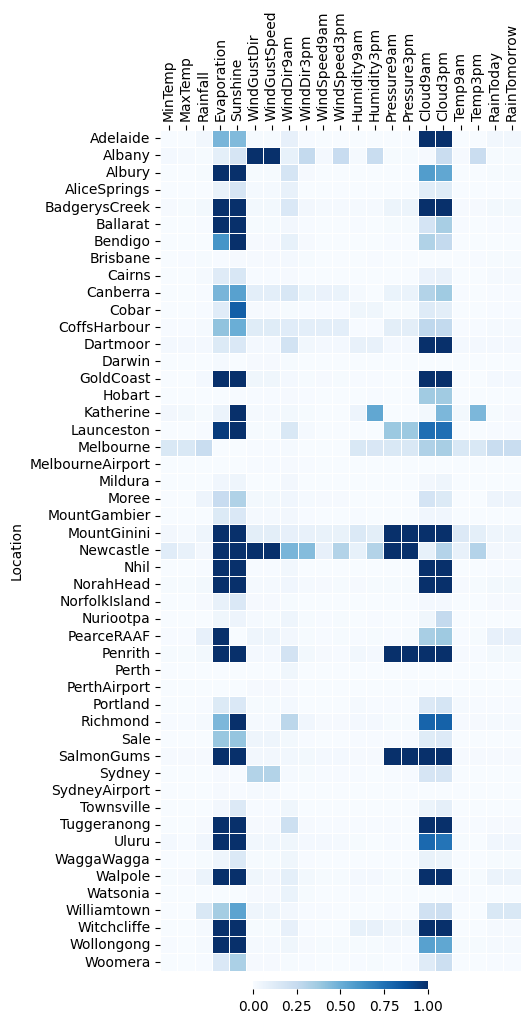

In [87]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    tmp = (data
           .groupby('Location')
           .apply(lambda x:
                  x.drop(['Location', 'Date'], axis=1)
                  .isna()
                  .mean()))

plt.figure(figsize=(9, 13))

ax = sns.heatmap(tmp,
                 cmap='Blues',
                 linewidth=0.5,
                 square=True,
                 cbar_kws=dict(
                     location="bottom",
                     pad=0.01,
                     shrink=0.25))

ax.xaxis.tick_top()
ax.tick_params(axis='x', labelrotation=90)

In [88]:
data = data[data.columns[data.isna().mean().lt(0.35)]]

data = data.dropna(subset='RainTomorrow')

### Огляд даних за типами

In [89]:
data_num = data.select_dtypes(include=np.number)
data_cat = data.select_dtypes(include='object')

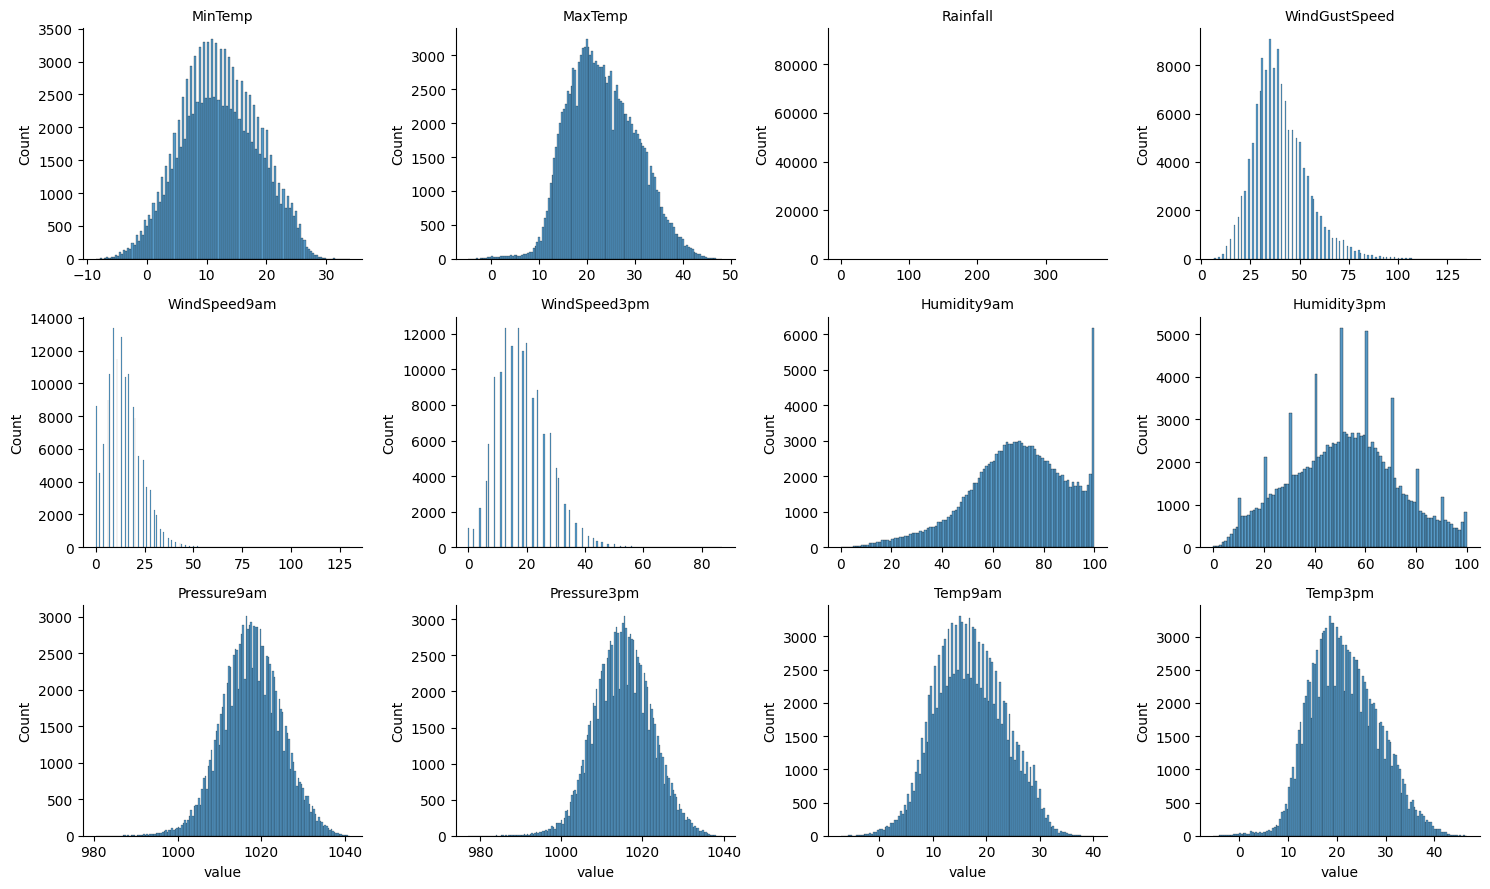

In [90]:
melted = data_num.melt()

g = sns.FacetGrid(melted,
                  col='variable',
                  col_wrap=4,
                  sharex=False,
                  sharey=False,
                  aspect=1.25)

g.map(sns.histplot, 'value')

g.set_titles(col_template='{col_name}')

g.tight_layout()

In [91]:
data_cat.nunique()

Date            3436
Location          49
WindGustDir       16
WindDir9am        16
WindDir3pm        16
RainToday          2
RainTomorrow       2
dtype: int64

In [92]:
data_cat.apply(lambda x: x.unique()[:5])

Date            [2008-12-01, 2008-12-02, 2008-12-03, 2008-12-0...
Location        [Albury, BadgerysCreek, Cobar, CoffsHarbour, M...
WindGustDir                                [W, WNW, WSW, NE, NNW]
WindDir9am                                  [W, NNW, SE, ENE, SW]
WindDir3pm                                   [WNW, WSW, E, NW, W]
RainToday                                          [No, Yes, nan]
RainTomorrow                                            [No, Yes]
dtype: object

In [93]:
data_cat['Date'] = pd.to_datetime(data['Date'])

data_cat[['Year', 'Month']] = (data_cat['Date']
                               .apply(lambda x:
                                      pd.Series([x.year, x.month])))

data_cat.drop('Date', axis=1, inplace=True)

data_cat[['Year', 'Month']] = data_cat[['Year', 'Month']].astype(str)

data_cat[['Year', 'Month']].head()

,Year,Month
0,2008,12
1,2008,12
2,2008,12
3,2008,12
4,2008,12


# Практика застосування логістичної регресії. Підготовка й обробка даних

3.3. Зміна типа колонки DATE на тип DATETIME та створення додаткових колонок  YEAR та  MONTH

In [94]:
# Конвертація колонки 'Date' до типу datetime
data['Date'] = pd.to_datetime(data['Date'])

# Створення нових колонок 'Year' і 'Month' із колонки 'Date'
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month

# Перегляд перших кількох записів для перевірки нових колонок
data[['Date', 'Year', 'Month']].head()


,Date,Year,Month
0,2008-12-01,2008,12
1,2008-12-02,2008,12
2,2008-12-03,2008,12
3,2008-12-04,2008,12
4,2008-12-05,2008,12


Крок 3.1: Видалення колонок з великою кількістю пропущених значень

In [95]:
# Визначення колонок з більш ніж 30% пропущених значень
high_na_columns = data.columns[data.isna().mean() > 0.3]

# Видалення цих колонок з датасету
data.drop(columns=high_na_columns, inplace=True)

# Перевірка оновленої структури даних
print(data.isna().mean().sort_values(ascending=False))


Pressure9am      0.098556
Pressure3pm      0.098324
WindDir9am       0.070418
WindGustDir      0.065615
WindGustSpeed    0.065193
WindDir3pm       0.026570
Humidity3pm      0.025388
Temp3pm          0.019171
WindSpeed3pm     0.018496
Humidity9am      0.012476
RainToday        0.009888
Rainfall         0.009888
WindSpeed9am     0.009480
Temp9am          0.006358
MinTemp          0.004480
MaxTemp          0.002265
Year             0.000000
RainTomorrow     0.000000
Date             0.000000
Location         0.000000
Month            0.000000
dtype: float64


Крок 3.2: Розділення даних на числові та категоріальні підмножини

In [96]:
# Визначення числових колонок
numerical_cols = data.select_dtypes(include=['int64', 'float64']).columns

# Визначення категоріальних колонок
categorical_cols = data.select_dtypes(include=['object']).columns

# Створення підмножин для числових та категоріальних даних
numerical_data = data[numerical_cols]
categorical_data = data[categorical_cols]

# Перегляд назв колонок для кожної підмножини
print("Numerical columns:", numerical_cols)
print("Categorical columns:", categorical_cols)


Numerical columns: Index(['MinTemp', 'MaxTemp', 'Rainfall', 'WindGustSpeed', 'WindSpeed9am',
       'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am',
       'Pressure3pm', 'Temp9am', 'Temp3pm'],
      dtype='object')
Categorical columns: Index(['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday',
       'RainTomorrow'],
      dtype='object')


Крок 3.4: Переміщення колонки 'Year' до числових ознак

In [97]:
# Переміщення колонки 'Year' до числових даних
if 'Year' in categorical_data:
    numerical_data['Year'] = categorical_data.pop('Year')

# Виведення інформації про числові та категоріальні дані після змін
print(numerical_data.head())
print(categorical_data.head())


   MinTemp  MaxTemp  Rainfall  WindGustSpeed  WindSpeed9am  WindSpeed3pm  \
0     13.4     22.9       0.6           44.0          20.0          24.0   
1      7.4     25.1       0.0           44.0           4.0          22.0   
2     12.9     25.7       0.0           46.0          19.0          26.0   
3      9.2     28.0       0.0           24.0          11.0           9.0   
4     17.5     32.3       1.0           41.0           7.0          20.0   

   Humidity9am  Humidity3pm  Pressure9am  Pressure3pm  Temp9am  Temp3pm  
0         71.0         22.0       1007.7       1007.1     16.9     21.8  
1         44.0         25.0       1010.6       1007.8     17.2     24.3  
2         38.0         30.0       1007.6       1008.7     21.0     23.2  
3         45.0         16.0       1017.6       1012.8     18.1     26.5  
4         82.0         33.0       1010.8       1006.0     17.8     29.7  
  Location WindGustDir WindDir9am WindDir3pm RainToday RainTomorrow
0   Albury           W         

In [98]:
# Перевірка наявності колонки 'Month' у числових даних
if 'Month' in numerical_data.columns:
    # Переміщення колонки 'Month' до категоріальних даних
    categorical_data['Month'] = numerical_data.pop('Month')

# Виведення оновлених структур даних
print("Updated Numerical Data Columns:", numerical_data.columns)
print("Updated Categorical Data Columns:", categorical_data.columns)


Updated Numerical Data Columns: Index(['MinTemp', 'MaxTemp', 'Rainfall', 'WindGustSpeed', 'WindSpeed9am',
       'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am',
       'Pressure3pm', 'Temp9am', 'Temp3pm'],
      dtype='object')
Updated Categorical Data Columns: Index(['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday',
       'RainTomorrow'],
      dtype='object')


In [118]:
# Відновлення колонок 'Year' і 'Month'
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month

# Додавання 'Year' до числових даних і 'Month' до категоріальних даних
# Змінено з безпосереднього присвоєння на використання .loc для уникнення попереджень
numerical_data.loc[:, 'Year'] = data['Year']
categorical_data.loc[:, 'Month'] = data['Month']

# Перевірка наявності оновлених колонок
print("Updated Numerical Data Columns:", numerical_data.columns)
print("Updated Categorical Data Columns:", categorical_data.columns)



Updated Numerical Data Columns: Index(['MinTemp', 'MaxTemp', 'Rainfall', 'WindGustSpeed', 'WindSpeed9am',
       'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am',
       'Pressure3pm', 'Temp9am', 'Temp3pm', 'Year'],
      dtype='object')
Updated Categorical Data Columns: Index(['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday',
       'RainTomorrow', 'Month'],
      dtype='object')


Крок 3.5: Розділення на тренувальні та тестові вибірки

In [119]:
# Визначення максимального року в даних
max_year = data['Year'].max()

# Розділення даних на тренувальні та тестові вибірки
train_data = data[data['Year'] < max_year]
test_data = data[data['Year'] == max_year]

# Виведення розміру тренувальної та тестової вибірки
print("Training data shape:", train_data.shape)
print("Testing data shape:", test_data.shape)


Training data shape: (133727, 21)
Testing data shape: (8466, 21)


Крок 4: Імпутація пропущених значень

In [120]:
from sklearn.impute import SimpleImputer

# Імпутація для числових змінних
num_imputer = SimpleImputer(strategy='mean')
numerical_data_imputed = num_imputer.fit_transform(numerical_data)
numerical_data_imputed = pd.DataFrame(numerical_data_imputed, columns=numerical_data.columns)

# Імпутація для категоріальних змінних
cat_imputer = SimpleImputer(strategy='most_frequent')
categorical_data_imputed = cat_imputer.fit_transform(categorical_data)
categorical_data_imputed = pd.DataFrame(categorical_data_imputed, columns=categorical_data.columns)

# Перевірка результатів імпутації
print(numerical_data_imputed.isna().sum())
print(categorical_data_imputed.isna().sum())


MinTemp          0
MaxTemp          0
Rainfall         0
WindGustSpeed    0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Temp9am          0
Temp3pm          0
Year             0
dtype: int64
Location        0
WindGustDir     0
WindDir9am      0
WindDir3pm      0
RainToday       0
RainTomorrow    0
Month           0
dtype: int64


Крок 5: Нормалізація числових ознак

In [121]:
from sklearn.preprocessing import StandardScaler

# Нормалізація числових даних
scaler = StandardScaler()
numerical_data_normalized = scaler.fit_transform(numerical_data_imputed)
numerical_data_normalized = pd.DataFrame(numerical_data_normalized, columns=numerical_data_imputed.columns)

# Перевірка нормалізованих даних
numerical_data_normalized.head()


,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,Year
0,0.189954,-0.045964,-0.207757,0.305648,0.677661,0.614850,0.113891,-1.435935,-1.475456,-1.220966,-0.013521,0.016412,-1.872674
1,-0.749174,0.263480,-0.278989,0.305648,-1.130034,0.385532,-1.312265,-1.289821,-1.045586,-1.116203,0.032832,0.380274,-1.872674
2,0.111694,0.347873,-0.278989,0.457874,0.564680,0.844167,-1.629188,-1.046299,-1.490279,-0.981508,0.619963,0.220175,-1.872674
3,-0.467436,0.671383,-0.278989,-1.216614,-0.339167,-1.105034,-1.259444,-1.728162,-0.007969,-0.367897,0.171889,0.700472,-1.872674
4,0.831692,1.276205,-0.160269,0.077309,-0.791091,0.156214,0.694918,-0.900186,-1.015940,-1.385593,0.125537,1.166215,-1.872674


Крок 6: Кодування категоріальних ознак

In [122]:
from sklearn.preprocessing import OneHotEncoder

# Кодування категоріальних даних
encoder = OneHotEncoder(sparse_output=False)  # Якщо ви хочете отримати dense матрицю безпосередньо
categorical_data_encoded = encoder.fit_transform(categorical_data_imputed)
categorical_data_encoded = pd.DataFrame(categorical_data_encoded, columns=encoder.get_feature_names_out())

# Перевірка закодованих даних
categorical_data_encoded.head()



,Location_Adelaide,Location_Albany,Location_Albury,Location_AliceSprings,Location_BadgerysCreek,Location_Ballarat,Location_Bendigo,Location_Brisbane,Location_Cairns,Location_Canberra,...,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Крок 7:Імпутація та масштабування числових даних

In [123]:
# Об'єднання числових та категоріальних підмножин
final_train_data = pd.concat([numerical_data_normalized, categorical_data_encoded], axis=1)

# Перевірка фінального датасету
final_train_data.head()


,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,...,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
0,0.189954,-0.045964,-0.207757,0.305648,0.677661,0.614850,0.113891,-1.435935,-1.475456,-1.220966,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,-0.749174,0.263480,-0.278989,0.305648,-1.130034,0.385532,-1.312265,-1.289821,-1.045586,-1.116203,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.111694,0.347873,-0.278989,0.457874,0.564680,0.844167,-1.629188,-1.046299,-1.490279,-0.981508,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,-0.467436,0.671383,-0.278989,-1.216614,-0.339167,-1.105034,-1.259444,-1.728162,-0.007969,-0.367897,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.831692,1.276205,-0.160269,0.077309,-0.791091,0.156214,0.694918,-0.900186,-1.015940,-1.385593,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Крок 8: Підготовка цільової змінної та розділення даних на тренувальні та тестові вибірки

In [126]:
# Цільова змінна
y = data['RainTomorrow'].map({'No': 0, 'Yes': 1}).astype(int)

# Розділення даних на тренувальні та тестові вибірки
X_train, X_test, y_train, y_test = train_test_split(final_train_data, y, test_size=0.2, random_state=42)

# Перевірка розмірів вибірок
print("Training features shape:", X_train.shape)
print("Testing features shape:", X_test.shape)
print("Training labels shape:", y_train.shape)
print("Testing labels shape:", y_test.shape)


Training features shape: (113754, 126)
Testing features shape: (28439, 126)
Training labels shape: (113754,)
Testing labels shape: (28439,)


Крок 9: Навчання моделі логістичної регресії

In [127]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Створення та навчання моделі логістичної регресії
model = LogisticRegression(solver='liblinear', random_state=42)
model.fit(X_train, y_train)

# Прогнозування на тестових даних
predictions = model.predict(X_test)

# Оцінка моделі
report = classification_report(y_test, predictions, target_names=['No Rain', 'Rain'])
print(report)



              precision    recall  f1-score   support

     No Rain       1.00      1.00      1.00     22098
        Rain       1.00      1.00      1.00      6341

    accuracy                           1.00     28439
   macro avg       1.00      1.00      1.00     28439
weighted avg       1.00      1.00      1.00     28439



Оцінка моделі

In [129]:
X_test = test_df.drop('RainTomorrow', axis=1)
y_test = test_df['RainTomorrow']
pred = clf.predict(X_test)

# Відображення матриці помилок
ConfusionMatrixDisplay.from_predictions(y_test, pred)
plt.show()

# Звіт класифікації
print(classification_report(y_test, pred))


NameError: name 'test_df' is not defined

### Відновлення пропущених значень

Крок 9: Навчання моделі логістичної регресії

In [59]:
num_imputer = SimpleImputer().set_output(transform='pandas')
X_train_num = num_imputer.fit_transform(X_train_num)
X_test_num = num_imputer.transform(X_test_num)

pd.concat([X_train_num, X_test_num]).isna().sum()

MinTemp          0
MaxTemp          0
Rainfall         0
WindGustSpeed    0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Temp9am          0
Temp3pm          0
dtype: int64

In [60]:
cat_imputer = SimpleImputer(
    strategy='most_frequent').set_output(transform='pandas')
X_train_cat = cat_imputer.fit_transform(X_train_cat)
X_test_cat = cat_imputer.transform(X_test_cat)

pd.concat([X_train_cat, X_test_cat]).isna().sum()

Location       0
WindGustDir    0
WindDir9am     0
WindDir3pm     0
RainToday      0
Year           0
Month          0
dtype: int64

### Нормалізація змінних

In [23]:
scaler = StandardScaler().set_output(transform='pandas')

X_train_num = scaler.fit_transform(X_train_num)
X_test_num = scaler.transform(X_test_num)

### Onehot кодування категоріальних змінних

In [24]:
encoder = (OneHotEncoder(drop='if_binary',
                         sparse_output=False)
           .set_output(transform='pandas'))

X_train_cat = encoder.fit_transform(X_train_cat)
X_test_cat = encoder.transform(X_test_cat)

X_train_cat.shape

(113754, 121)

In [79]:
X_train = pd.concat([X_train_num, X_train_cat], axis=1)
X_test = pd.concat([X_test_num, X_test_cat], axis=1)

X_train.shape

(113754, 19)

# Практика застосування логістичної регресії. Навчання й оцінка моделі

### Розподіл цільової змінної

In [64]:
y_train.value_counts(normalize=True)

RainTomorrow
0    0.775516
1    0.224484
Name: proportion, dtype: float64

In [27]:
clf = (LogisticRegression(solver='liblinear',
                          class_weight='balanced',
                          random_state=42)
       .fit(X_train, y_train))

pred = clf.predict(X_test)

### Оцінювання точності моделі

In [65]:
ConfusionMatrixDisplay.from_predictions(y_test, pred)

ValueError: Mix of label input types (string and number)

In [80]:
print(classification_report(y_test, pred))

TypeError: Labels in y_true and y_pred should be of the same type. Got y_true=[0 1] and y_pred=['No' 'Yes']. Make sure that the predictions provided by the classifier coincides with the true labels.